# Creacion del script de pronostico de energia para los parques eolicos

## Importacion de las bibliotecas

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

#from openpyxl import load_workbook

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Importacion del dataset para obtener las observaciones

In [2]:
df_Prueba = pd.read_csv('./Datasets/Nizanda_22_Prueba.csv')
df_Prueba

,Day,Month,Year,Hour,Barometer,Temp C,High Temp C,Low Temp C,Hum %,Dew Point C,...,Wind Run,High Wind Speed m/s,High Wind Direction,Wind Chill C,Heat Index C,THW Index C,Rain mm,Rain Rate mm/h,ET mm,Date
0,1,1,2022,0,758.9,25.4,25.6,25.3,88.0,23.3,...,1.79,5.4,S,25.4,27.6,27.6,0.0,0.0,0.03,2022-01-01 00:00:00
1,1,1,2022,1,758.7,25.0,25.4,25.0,89.0,23.1,...,1.79,4.9,S,25.0,27.0,27.0,0.0,0.0,0.03,2022-01-01 01:00:00
2,1,1,2022,2,758.2,24.5,25.1,24.5,89.0,22.6,...,1.34,4.5,SSE,24.5,26.2,26.2,0.0,0.0,0.03,2022-01-01 02:00:00
3,1,1,2022,3,757.9,23.8,24.5,23.8,92.0,22.5,...,0.89,4.0,SSW,23.8,25.4,25.4,0.0,0.0,0.03,2022-01-01 03:00:00
4,1,1,2022,4,758.0,23.8,23.9,23.7,91.0,22.2,...,0.89,4.5,SSE,23.8,25.3,25.3,0.0,0.0,0.00,2022-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,31,12,2022,19,759.2,28.7,29.6,28.7,61.0,20.5,...,2.24,8.5,W,28.7,30.7,30.7,0.0,0.0,0.08,2022-12-31 19:00:00
8756,31,12,2022,20,759.6,28.3,28.8,28.3,63.0,20.6,...,1.79,7.6,ENE,28.3,30.3,30.3,0.0,0.0,0.08,2022-12-31 20:00:00
8757,31,12,2022,21,760.1,27.7,28.3,27.7,67.0,21.0,...,1.79,6.7,NW,27.7,29.9,29.9,0.0,0.0,0.08,2022-12-31 21:00:00
8758,31,12,2022,22,760.5,27.2,27.8,27.2,73.0,21.9,...,2.24,8.5,NE,27.2,29.7,29.7,0.0,0.0,0.05,2022-12-31 22:00:00


## Funciones a utilizar

In [3]:
def previous_date(current_date, frmt='%Y-%m-%d-%H', days = 1, string=True):
    yesterday = current_date - timedelta(days)
    if string:
        return yesterday.strftime(frmt), current_date.strftime(frmt)
    return yesterday

In [4]:
def get_dates(data, month, day, d = 1):
    current_date = datetime(2022, month, day)
    
    prev, current = previous_date(current_date, days = d + 1, string = True)
    month = data[(data['Date'] > prev) & (data['Date'] < current)]
    print(month)
    previous_days = month.iloc[:-24]
    current_day = month.iloc[len(previous_days):]
    
    return month, previous_days, current_day

In [17]:
def pronostico(Month, Day, model_type):
    obs = 0
    if(model_type == 'M-SVR'):
        obs = 2
    elif(model_type == 'LR'):
        obs = 4
    
    month, p, c = get_dates(df_Prueba, Month, Day, d = obs)

    drop_cols = [col for col in p.columns if col not in ['High Wind Speed m/s']]
    p.drop(drop_cols, axis = 1, inplace = True)
    
    win = p
    
    # MULTIPLE OUTPUT
    win_scl = scaler.transform(win)
    win_scl = win_scl.reshape(1, -1)
    pred = model.predict(win_scl)
        
    ### PARA SINGLE INPUT
    # se realiza la transformacion inversa del scaler para los datos de las predicciones
    p_inv = scaler.inverse_transform(pred)
        
    p_inv = p_inv.flatten()
    
    return p_inv

In [16]:
def pronostico_LSTM(Month, Day):

    month, p, c = get_dates(df_Prueba, Month, Day, d = 4)
    drop_cols = [col for col in p.columns if col not in ['Month', 'Day', 'Hour', 'High Wind Speed m/s']]
    p.drop(drop_cols, axis = 1, inplace = True)
    
    x_input = p.values
    x_input_s = scaler.transform(x_input)
    x_input_s = x_input_s.flatten()
    
    x_input_s = x_input_s.reshape(1, 96, 4)
    pred = model.predict(x_input_s, verbose=0)
    
    return pred.flatten()
    

## Experimentacion del script

In [7]:
# NECESARIO PARA CARGAR EL MODELO
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, params = None):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None
        
        if params != None:
            self.C = params['C'][0]
            self.epsilon = params['epsilon'][0]
            self.gamma = params['gamma'][0]
            self.kernel = params['kernel'][0]
        #print(str(self.C))

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

In [8]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

### Utilizando M-SVR

In [9]:
## Cargando el modelo y el scaler
model = pickle.load(open('model_istmo.pkl', 'rb'))
scaler = pickle.load(open('scaler_istmo.pkl', 'rb'))
model_type = 'M-SVR'

### Utilizando Regresion Lineal

In [10]:
## Cargando el modelo y el scaler
model = pickle.load(open('model_LR.pkl', 'rb'))
scaler = pickle.load(open('scaler_LR.pkl', 'rb'))
model_type = 'LR'

### Pronostico con M-SVR o LR (demostracion)

In [11]:
resultado = pronostico(5, 1, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento

      Day  Month  Year  Hour  Barometer  Temp C  High Temp C  Low Temp C  \
2784   27      4  2022     0      760.7    22.2         25.1        22.1   
2785   27      4  2022     1      760.6    22.6         22.6        21.9   
2786   27      4  2022     2      760.0    22.9         23.4        22.6   
2787   27      4  2022     3      759.9    21.5         23.0        21.4   
2788   27      4  2022     4      759.2    23.3         23.4        21.4   
...   ...    ...   ...   ...        ...     ...          ...         ...   
2899    1      5  2022    19      756.0    32.1         33.4        32.1   
2900    1      5  2022    20      756.3    30.5         32.1        30.5   
2901    1      5  2022    21      757.3    29.1         30.5        29.1   
2902    1      5  2022    22      757.9    28.6         29.1        28.6   
2903    1      5  2022    23      758.1    28.4         28.6        28.4   

      Hum %  Dew Point C  ...  Wind Run High Wind Speed m/s  \
2784   86.0         19.7

### Utilizando LSTM

In [20]:
## Cargando el modelo y el scaler
#model = pickle.load(open('model_LSTM.pkl', 'rb'))
model = keras.models.load_model('model_LSTM.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
scaler = pickle.load(open('scaler_LSTM.pkl', 'rb'))
model_type = 'LSTM'

# Realizando la prediccion de la velocidad del viento
#resultado = pronostico(5, 3, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
scl_inv = MinMaxScaler()
scl_inv.min_, scl_inv.scale_ = scaler.min_[3], scaler.scale_[3]

resultado = pronostico_LSTM(5, 3)
resultado = scl_inv.inverse_transform(resultado.reshape(-1, 1))
resultado =  resultado.flatten()

m, p, c = get_dates(df_Prueba, 1, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)

      Day  Month  Year  Hour  Barometer  Temp C  High Temp C  Low Temp C  \
2832   29      4  2022     0      758.0    26.6         27.4        26.6   
2833   29      4  2022     1      757.8    25.9         26.6        25.9   
2834   29      4  2022     2      757.4    25.8         25.9        25.7   
2835   29      4  2022     3      756.9    25.8         25.9        25.7   
2836   29      4  2022     4      756.7    25.5         25.8        25.4   
...   ...    ...   ...   ...        ...     ...          ...         ...   
2947    3      5  2022    19      756.0    30.9         32.4        30.9   
2948    3      5  2022    20      756.2    29.5         30.9        29.5   
2949    3      5  2022    21      757.0    28.5         29.6        28.5   
2950    3      5  2022    22      757.6    28.0         28.5        28.0   
2951    3      5  2022    23      758.2    28.0         28.1        27.9   

      Hum %  Dew Point C  ...  Wind Run High Wind Speed m/s  \
2832   76.0         22.0

ValueError: X has 1 features, but MinMaxScaler is expecting 4 features as input.

### Dias solicitados

In [8]:
## Cargando el modelo y el scaler
model = pickle.load(open('model_istmo.pkl', 'rb'))
scaler = pickle.load(open('scaler_istmo.pkl', 'rb'))
model_type = 'M-SVR'

In [13]:
## Arreglos de la velocidad del viento a energia de los parques eolicos: requerido para realizar la conversion viento-energia
E_v_m_s = [0,1,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14,15,16,17,18,19,20,21,21.5,22,22.5,23,23.5,24,24.5,25]
E_energia_mwh = [0,0,0,0,5.112,9.94,15.478,22.294,29.962,38.056,47.996,60.634,79.804,89.744,105.932,121.978,139.302,156.2,174.234,192.126,205.9,213,213,213,213,213,213,213,213,213,213,213,213,213,213,0,0,0,0,0]

B_v_m_s = [0,1,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14,15,16,17,18,19,20,21,21.5,22,22.5,23,23.5,24,24.4,25]
B_energia_mwh = [0,0,0,2.106,3.159,6.084,9.009,14.391,19.89,28.197,36.504,49.959,63.414,83.655,103.896,124.956,146.133,166.608,187.2,204.75,222.417,230.49,234,234,234,234,234,234,234,234,234,234,229.32,221.13,208.962,196.794,182.403,168.012,151.632,135.252]

Eo_v_m_s = [0,1,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14,15,16,17,18,19,20,21,21.5,22,22.5,23,23.5,24,24.5,25]
Eo_energia_mwh = [0,0,0,0,0.7,1.42,2.62,3.82,5.66,7.48,9.38,11.3,14.4,17.52,21.34,25.14,29.66,34.18,38.8,43.02,45.2,46.9,48.4,49.2,49.8,50,50,50,50,50,50,50,50,50,50,50,50,0,0,0]

#### 15 Enero

In [14]:
# pronostico
resultado = pronostico(1, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 1, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)

     Day  Month  Year  Hour  Barometer  Temp C  High Temp C  Low Temp C  \
336   15      1  2022     0      759.9    20.5         22.8        20.5   
337   15      1  2022     1      759.6    19.3         20.5        19.3   
338   15      1  2022     2      759.4    18.3         19.3        18.3   
339   15      1  2022     3      759.1    17.8         18.3        17.8   
340   15      1  2022     4      758.6    18.1         18.2        17.8   
341   15      1  2022     5      759.0    19.7         19.7        18.1   
342   15      1  2022     6      759.3    21.2         21.2        19.7   
343   15      1  2022     7      760.2    21.4         21.6        21.2   
344   15      1  2022     8      760.3    21.6         21.6        21.3   
345   15      1  2022     9      761.0    23.2         23.2        21.6   
346   15      1  2022    10      761.6    26.7         26.7        23.2   
347   15      1  2022    11      761.0    27.0         27.6        26.7   
348   15      1  2022    

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Day
- Hour
- Month


NameError: name 'c' is not defined

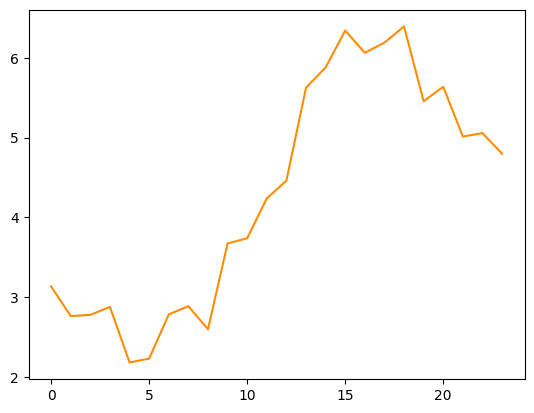

In [19]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Enero' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

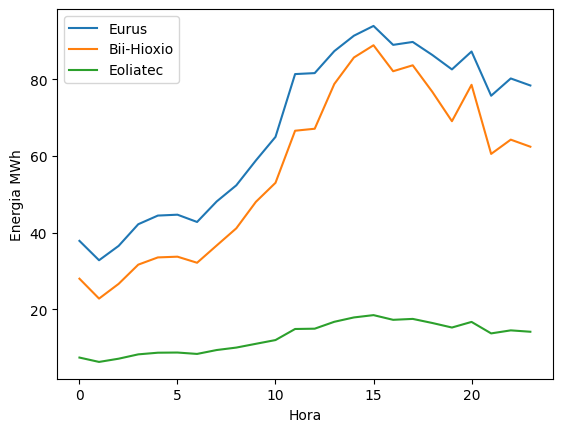

In [14]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Enero' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

#### 15 Abirl

In [15]:
# pronostico
resultado = pronostico(4, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 4, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Abril' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Abril' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

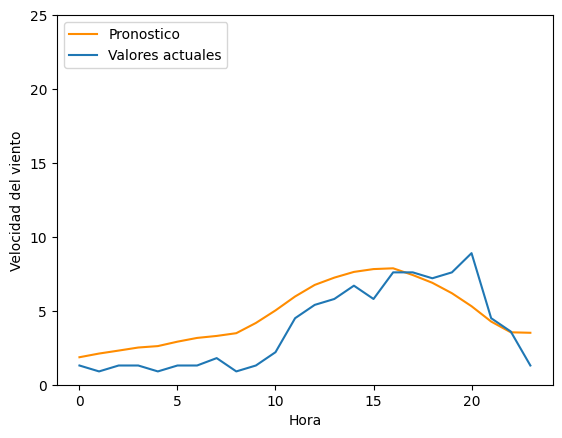

In [16]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Abril' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

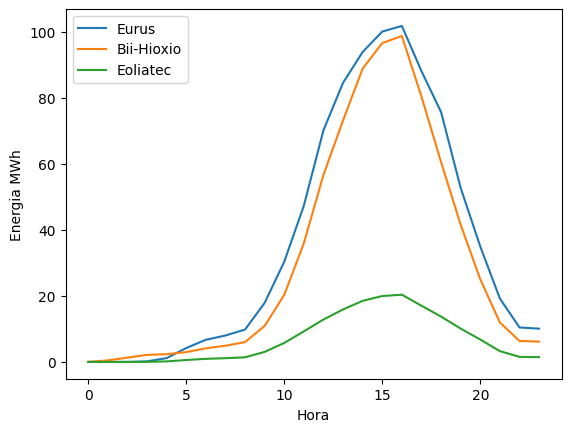

In [17]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Abril' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

#### 15 Junio

In [18]:
# pronostico
resultado = pronostico(6, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 6, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Junio' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Junio' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

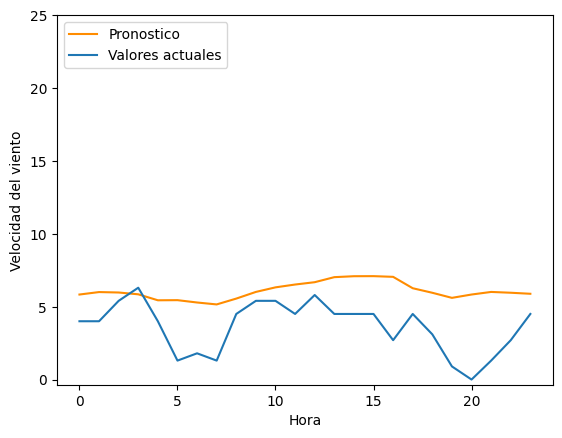

In [19]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Junio' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

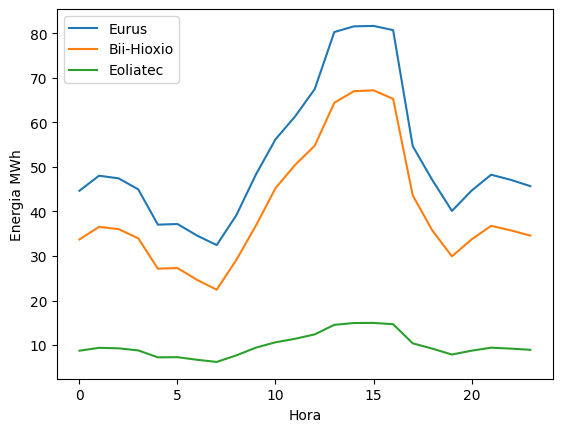

In [20]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Junio' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

#### 15 Octubre

In [21]:
# pronostico
resultado = pronostico(10, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 10, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Octubre' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Octubre' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

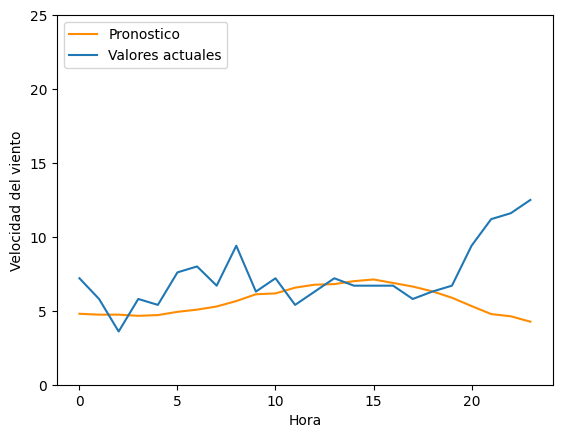

In [22]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Octubre' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

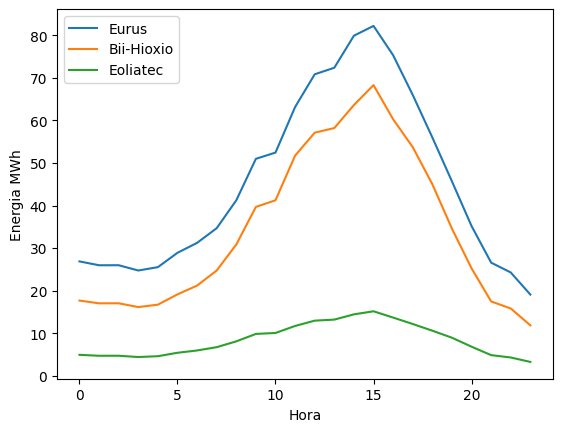

In [23]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Octubre' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

### Dias extras

In [10]:
df_Paredon = pd.read_csv('./Datasets/Estacion_PAREDON_1_semana.csv')
df_Paredon

,Fecha Local,Rapidez de viento (km/h),Rapidez de ráfaga (km/h),Temperatura del Aire (°C),Humedad relativa (%),Presión Atmosférica (hpa),Precipitación (mm),Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,2024-03-05 18:45:00,5.3,10.1,28.6,62.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2024-03-05 18:30:00,5.9,9.4,29.0,60.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2024-03-05 18:15:00,5.3,9.7,29.4,59.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2024-03-05 18:00:00,7.8,12.6,29.8,58.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2024-03-05 17:45:00,9.3,14.8,30.3,55.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_Paredon = df_Paredon[['Fecha Local', 'Rapidez de viento (km/h)']]

In [12]:
df_Paredon = df_Paredon[['Fecha Local', 'Rapidez de viento (km/h)']]
df_Paredon.dropna(inplace = True)
df_Paredon['Fecha Local'] = pd.to_datetime(df_Paredon['Fecha Local'], format = '%Y-%m-%d %H:%M:%S')

In [13]:
df_Paredon.columns

Index(['Fecha Local', 'Rapidez de viento (km/h)'], dtype='object')

In [14]:
df_Paredon['Fecha Local'] = pd.to_datetime(df_Paredon['Fecha Local'], format = '%Y-%m-%d %H:%M:%S')

In [15]:
#df_Paredon[['Fecha Local'] < datetime.minute(0)]
#df_filtered = df[df['date'].dt.strftime('%Y') == '2014']
df_Paredon = df_Paredon[df_Paredon['Fecha Local'].dt.strftime('%M') == '00']
df_Paredon

,Fecha Local,Rapidez de viento (km/h)
3,2024-03-05 18:00:00,7.8
7,2024-03-05 17:00:00,10.2
11,2024-03-05 16:00:00,12.7
15,2024-03-05 15:00:00,12.2
19,2024-03-05 14:00:00,11.0
...,...,...
647,2024-02-28 01:00:00,2.0
651,2024-02-28 00:00:00,2.7
655,2024-02-27 23:00:00,2.5
659,2024-02-27 22:00:00,2.1


In [16]:
df_Paredon = df_Paredon[df_Paredon['Fecha Local'].dt.strftime('%M') == '00']
df_Paredon.rename(columns={'Fecha Local': 'Fecha', 'Rapidez de viento (km/h)': 'Rapidez de viento (km/h)'}, inplace=True)

In [17]:
df_Paredon = df_Paredon.query("Fecha >= '2024-03-2' and Fecha <= '2024-03-4'")

In [18]:
df_Paredon

,Fecha,Rapidez de viento (km/h)
171,2024-03-04 00:00:00,2.4
175,2024-03-03 23:00:00,2.9
179,2024-03-03 22:00:00,2.3
183,2024-03-03 21:00:00,2.3
187,2024-03-03 20:00:00,0.9
191,2024-03-03 19:00:00,1.5
195,2024-03-03 18:00:00,5.7
199,2024-03-03 17:00:00,8.5
203,2024-03-03 16:00:00,10.0
207,2024-03-03 15:00:00,10.9


In [19]:
#Conversion de km/h a m/s
df_Paredon['Velocidad del viento m/s'] = df_Paredon['Rapidez de viento (km/h)'].transform(lambda x: x / 3.6)

In [20]:
df_Paredon.drop(171, inplace=True)

In [21]:
df_Paredon['Velocidad del viento m/s']

175    0.805556
179    0.638889
183    0.638889
187    0.250000
191    0.416667
195    1.583333
199    2.361111
203    2.777778
207    3.027778
211    3.833333
215    3.305556
219    3.805556
223    3.472222
227    2.388889
231    1.472222
235    0.888889
239    0.694444
243    1.472222
247    0.555556
251    0.805556
255    0.444444
259    0.472222
263    0.666667
267    0.861111
271    0.722222
275    0.694444
279    0.444444
283    0.888889
287    0.583333
291    1.527778
295    2.333333
299    2.527778
303    3.055556
307    3.527778
311    3.888889
315    3.611111
319    2.861111
323    0.944444
327    0.527778
331    0.861111
335    0.722222
339    0.111111
343    0.083333
347    0.388889
351    0.777778
355    0.527778
359    0.416667
363    0.555556
Name: Velocidad del viento m/s, dtype: float64

In [23]:
df_Paredon['Velocidad del viento m/s'].values[::-1]

array([0.55555556, 0.41666667, 0.52777778, 0.77777778, 0.38888889,
       0.08333333, 0.11111111, 0.72222222, 0.86111111, 0.52777778,
       0.94444444, 2.86111111, 3.61111111, 3.88888889, 3.52777778,
       3.05555556, 2.52777778, 2.33333333, 1.52777778, 0.58333333,
       0.88888889, 0.44444444, 0.69444444, 0.72222222, 0.86111111,
       0.66666667, 0.47222222, 0.44444444, 0.80555556, 0.55555556,
       1.47222222, 0.69444444, 0.88888889, 1.47222222, 2.38888889,
       3.47222222, 3.80555556, 3.30555556, 3.83333333, 3.02777778,
       2.77777778, 2.36111111, 1.58333333, 0.41666667, 0.25      ,
       0.63888889, 0.63888889, 0.80555556])

In [24]:
df_Paredon['Velocidad del viento m/s'].values.reshape(-1, 1)[::-1]

array([[0.55555556],
       [0.41666667],
       [0.52777778],
       [0.77777778],
       [0.38888889],
       [0.08333333],
       [0.11111111],
       [0.72222222],
       [0.86111111],
       [0.52777778],
       [0.94444444],
       [2.86111111],
       [3.61111111],
       [3.88888889],
       [3.52777778],
       [3.05555556],
       [2.52777778],
       [2.33333333],
       [1.52777778],
       [0.58333333],
       [0.88888889],
       [0.44444444],
       [0.69444444],
       [0.72222222],
       [0.86111111],
       [0.66666667],
       [0.47222222],
       [0.44444444],
       [0.80555556],
       [0.55555556],
       [1.47222222],
       [0.69444444],
       [0.88888889],
       [1.47222222],
       [2.38888889],
       [3.47222222],
       [3.80555556],
       [3.30555556],
       [3.83333333],
       [3.02777778],
       [2.77777778],
       [2.36111111],
       [1.58333333],
       [0.41666667],
       [0.25      ],
       [0.63888889],
       [0.63888889],
       [0.805

In [27]:
def pronostico_extra(df, model_type):
    obs = 0
    if(model_type == 'M-SVR'):
        obs = 2
    elif(model_type == 'LR'):
        obs = 4

    win = df['Velocidad del viento m/s'].values.reshape(-1, 1)[::-1]
    
    # MULTIPLE OUTPUT
    win_scl = scaler.transform(win)
    win_scl = win_scl.reshape(1, -1)
    pred = model.predict(win_scl)
        
    ### PARA SINGLE INPUT
    # se realiza la transformacion inversa del scaler para los datos de las predicciones
    p_inv = scaler.inverse_transform(pred)
        
    p_inv = p_inv.flatten()
    
    return p_inv

In [28]:
resultado = pronostico_extra(df_Paredon, model_type)

In [29]:
resultado

array([0.96545699, 0.97890027, 1.01893379, 1.07411254, 1.17702712,
       1.5159591 , 1.81185815, 2.33005136, 2.77846952, 3.32769794,
       3.64151445, 3.93322523, 3.87095378, 3.89241175, 3.82861796,
       3.67606989, 3.34450799, 3.00289925, 2.52683239, 2.3083093 ,
       2.04205547, 2.03452023, 2.05982782, 2.11973211])

In [30]:
df_actual = pd.read_csv('./Datasets/Estacion_PAREDON_1_semana.csv')
df_actual = df_actual[['Fecha Local', 'Rapidez de viento (km/h)']]
df_actual.dropna(inplace = True)
df_actual['Fecha Local'] = pd.to_datetime(df_actual['Fecha Local'], format = '%Y-%m-%d %H:%M:%S')
df_actual = df_actual[df_actual['Fecha Local'].dt.strftime('%M') == '00']
df_actual.rename(columns={'Fecha Local': 'Fecha', 'Rapidez de viento (km/h)': 'Rapidez de viento (km/h)'}, inplace=True)

actual = df_actual = df_actual.query("Fecha >= '2024-03-4' and Fecha < '2024-03-5'")
actual['Velocidad del viento m/s'] = actual['Rapidez de viento (km/h)'].transform(lambda x: x / 3.6)

In [33]:
actuales = actual['Velocidad del viento m/s'].values[::-1]

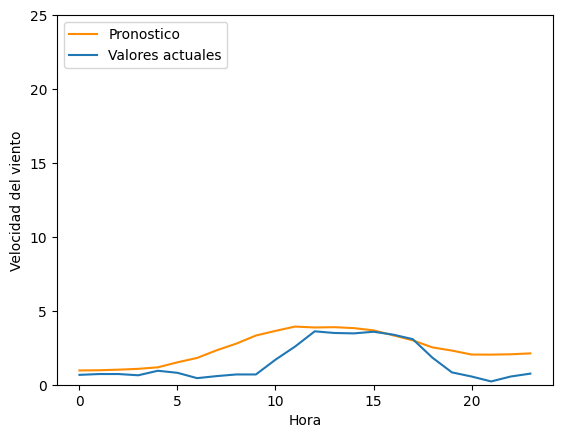

In [34]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(actuales, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
#plt.savefig('./Excel/pronostico_viento_' + 'Octubre' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()